# JanataHack - Predicting Customer Gender 

### Importing Packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit

# Classification models
import xgboost as xgb

from tqdm import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_columns = 50

### Importing Data

In [20]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sub = pd.read_csv("../data/sample_submission.csv")
sub.drop(['gender'], axis=1, inplace=True)

train.shape, test.shape, sub.shape

((10500, 5), (4500, 4), (4500, 1))

### Some utitlities for preprocessing data

In [21]:
def preprocess(train, test):

    train['startTime'] = pd.to_datetime(train['startTime'], format='%d/%m/%y %H:%M')
    test['startTime'] = pd.to_datetime(test['startTime'], format='%d/%m/%y %H:%M')
    train['endTime'] = pd.to_datetime(train['endTime'], format='%d/%m/%y %H:%M')
    test['endTime'] = pd.to_datetime(test['endTime'], format='%d/%m/%y %H:%M')
    
    train['Duration'] = train['endTime'] - train['startTime'] 
    train['Duration'] = train['Duration'].astype('timedelta64[m]')
    
    test['Duration'] = test['endTime'] - test['startTime'] 
    test['Duration'] = test['Duration'].astype('timedelta64[m]')
    
    train['ProductListCount'] = train['ProductList'].apply(lambda x: len(x.split(";")))
    test['ProductListCount'] = test['ProductList'].apply(lambda x: len(x.split(";")))
    
    return train, test

def create_time_feats(df, col, drop=True):
    
    # Extracting date features
    df[col + '_day_month'] = df[col].dt.day
    df[col + '_day_year'] = df[col].dt.dayofyear
    df[col + '_day_week'] = df[col].dt.dayofweek
    
    if drop:
        df.drop([col], axis=1, inplace=True)
    return df

### Preprocessing Data

In [22]:
train, test = preprocess(train, test)

### Extrapolating Data to utilize Product List : 

 - I've divided the products in the product list into record/row-wise i.e for example if a product_list contains 4 ";" seperated products then the extrapolated data will have 4 records each record representing 1 product mapped to session_id.
 
Example : 

    - Original Data
                
![image](../df_1.png)
     
    - New Extrapolated Data
                
![image](../df_2.png)

In [23]:
def extrapolate_data(train, test):
    train_list = []
    test_list = []

    for idx, row in tqdm_notebook(train.iterrows()):
        sess_id = row['session_id']
        start_time = row['startTime']
        end_time = row['endTime']
        gender = row['gender']
        product_count = row['ProductListCount']
        duration = row['Duration']

        products = row['ProductList'].split(';')
        products = [product.split("/") for product in products]

    #     first_product = products[0]
    #     last_product = products[-1]

        for product in products:
            train_list.append([sess_id, start_time, end_time, product[0], product[1], product[2], product[3],
    #                            first_product[0], first_product[1], first_product[2], first_product[3],
    #                            last_product[0], last_product[1], last_product[2], last_product[3],
                               product_count, duration, gender])

    for idx, row in tqdm_notebook(test.iterrows()):
        sess_id = row['session_id']
        start_time = row['startTime']
        end_time = row['endTime']
        product_count = row['ProductListCount']
        duration = row['Duration']
        
        products = row['ProductList'].split(';')
        products = [product.split("/") for product in products]

    #     first_product = products[0]
    #     last_product = products[-1]

        for product in products:
            test_list.append([sess_id, start_time, end_time, product[0], product[1], product[2], product[3],
    #                           first_product[0], first_product[1], first_product[2], first_product[3], 
    #                           last_product[0], last_product[1], last_product[2], last_product[3],
                              product_count, duration
                             ])

    print("Length of Train Set : \t{}\nLength of Test Set : \t{}".format(len(train_list), len(test_list)))
    
    train_df = pd.DataFrame(train_list, 
                            columns=['session_id', 'start_time', 'end_time', 'category_code', 'sub_category_code', 
                                     'sub_sub_category_code', 'product_code', 
    #                                  'first_category_code', 'first_sub_category_code', 'first_sub_sub_category_code',
    #                                  'first_product_code',
    #                                  'last_category_code', 'last_sub_category_code', 'last_sub_sub_category_code',
    #                                  'last_product_code',
                                     'product_list_count', 'duration', 
                                     'gender'])

    test_df = pd.DataFrame(test_list, 
                            columns=['session_id', 'start_time', 'end_time', 'category_code', 'sub_category_code', 
                                     'sub_sub_category_code', 'product_code', 
    #                                  'first_category_code', 'first_sub_category_code', 'first_sub_sub_category_code',
    #                                  'first_product_code',
    #                                  'last_category_code', 'last_sub_category_code', 'last_sub_sub_category_code',
    #                                  'last_product_code',
                                     'product_list_count', 'duration'
                                    ])

    train_df = create_time_feats(train_df, 'start_time', drop=True)
    train_df = create_time_feats(train_df, 'end_time', drop=True)
    test_df = create_time_feats(test_df, 'start_time', drop=True)
    test_df = create_time_feats(test_df, 'end_time', drop=True)
    
    return train_df, test_df

In [24]:
train, test = extrapolate_data(train, test)


Length of Train Set : 	23251
Length of Test Set : 	10204


In [25]:
target = 'gender'

### Feature Engineering

I had planned for multiple aggregated features but only some worked(improved score) in the end.
These are the target-aggregated features :
    
    1. category_code_female_probability : Denotes the female probability for a particular category code.
    2. sub_category_code_female_probability : Denotes the female probability for a particular sub-category code.
    
I did'nt do the same for sub_sub_category and product_code because there were many newer codes in test set which were not present in train set.

#### Calculating and merging the probability features

In [26]:
cat_probs = {}
sub_cat_probs = {}

for col, col_dict in tqdm_notebook(zip(
    ['category_code', 'sub_category_code'], 
    [cat_probs, sub_cat_probs])
                                  ):
    agg = pd.DataFrame(train.groupby([col])[target].value_counts())
    agg.columns = ['count']
    agg.reset_index(inplace=True)
    
    for idx, row in tqdm_notebook(agg.iterrows()):
        code = row[col]
        gender = row['gender']
        count = row['count']

        if code not in col_dict.keys():
            col_dict[code] = {}
        col_dict[code][gender] = count
        
for col_dict in tqdm_notebook([cat_probs, sub_cat_probs]):
    for key in col_dict.keys():
        if ('female' in col_dict[key].keys()) & ('male' in col_dict[key].keys()):
            col_dict[key]['female_prob'] = col_dict[key]['female'] / (col_dict[key]['female'] + 
                                                                  col_dict[key]['male'])
        elif ('female' in col_dict[key].keys()):
            col_dict[key]['female_prob'] = 1
        elif ('male' in col_dict[key].keys()):
            col_dict[key]['female_prob'] = 0
            
full_probs_list = []
for col_dict in tqdm_notebook([cat_probs, sub_cat_probs]):
    full_probs_list.append([(k, v['female_prob']) for k, v in col_dict.items()])

cat_prob_df = pd.DataFrame(full_probs_list[0], 
                           columns=['category_code', 'category_code_female_prob'])
sub_cat_prob_df = pd.DataFrame(full_probs_list[1], 
                               columns=['sub_category_code', 'sub_category_code_female_prob'])

train = pd.merge(train, cat_prob_df, on=['category_code'], how='left')
train = pd.merge(train, sub_cat_prob_df, on=['sub_category_code'], how='left')

test = pd.merge(test, cat_prob_df, on=['category_code'], how='left')
test = pd.merge(test, sub_cat_prob_df, on=['sub_category_code'], how='left')

print(train.shape, test.shape)


(23251, 16) (10204, 15)


In [27]:
train.head(3)

,session_id,category_code,sub_category_code,sub_sub_category_code,product_code,product_list_count,duration,gender,start_time_day_month,start_time_day_year,start_time_day_week,end_time_day_month,end_time_day_year,end_time_day_week,category_code_female_prob,sub_category_code_female_prob
0,u16159,A00002,B00003,C00006,D28435,4,1.0,female,15,349,0,15,349,0,0.903757,0.911156
1,u16159,A00002,B00003,C00006,D02554,4,1.0,female,15,349,0,15,349,0,0.903757,0.911156
2,u16159,A00002,B00003,C00006,D28436,4,1.0,female,15,349,0,15,349,0,0.903757,0.911156


### Encoding Categorical Variables

In [28]:
def encode_cat_cols(train_df, test_df, cat_cols, target):

    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    le_dict = {}

    for col in cat_cols:

        le = LabelEncoder()
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        train_df[col] = le.transform(train_df[[col]])
        test_df[col] = le.transform(test_df[[col]])

        le_dict[col] = le

    le = LabelEncoder()
    train_df[target] = le.fit_transform(train_df[[target]])
    
    le_dict[target] = le
    
    return train_df, test_df, le_dict

In [29]:
cat_cols = ['session_id', 'category_code', 'sub_category_code', 'sub_sub_category_code', 'product_code']
target = 'gender'

train, test, le_dict = encode_cat_cols(train, test, cat_cols, target)

In [30]:
feat = ['session_id',  'category_code',  'sub_category_code',  'sub_sub_category_code', 'product_code', 
        'product_list_count', 'duration', 'start_time_day_month', 'start_time_day_year', 'start_time_day_week',
        'end_time_day_month', 'end_time_day_week', 'category_code_female_prob',
        'sub_category_code_female_prob'
       ]

print("Length of features : {}".format(len(feat)))

Length of features : 14


### Train-Validation Splitting : 

As the data is very session_id grouped so the validation strategy should also be set in a way such that the train and validation sets have no session_id's in common because a common session_id creates a internal leakage because for 1 session_id there could only be 1 gender mapped.

Example : If train and validation set contains common session_id's then they could just overfit on session_id which would make other relevant features of null importance. 

**NOTE: Even though it's this type of splitting strategy is sensible, the public LB scores for normal train_test_split splits are higher, but here I'm only showing the above mentioned validation strategy**

### XBG Modelling

Iteration Number  : 1
[0]	train-error:0.097512	valid-error:0.093736
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[50]	train-error:0.067271	valid-error:0.090078
[100]	train-error:0.044341	valid-error:0.08642
[150]	train-error:0.026443	valid-error:0.07636
[200]	train-error:0.01823	valid-error:0.074074
[250]	train-error:0.013293	valid-error:0.074531
[300]	train-error:0.00959	valid-error:0.074074
Stopping. Best iteration:
[231]	train-error:0.015002	valid-error:0.070416

Best Iteration ::  231
Iteration Number  : 2
[0]	train-error:0.097259	valid-error:0.103492
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[50]	train-error:0.063914	valid-error:0.0954
[100]	train-error:0.043917	valid-error:0.089438
[150]	train-error:0.029039	valid-error:0.08816
[200]	train-error:0.017653	valid-error:0.083049

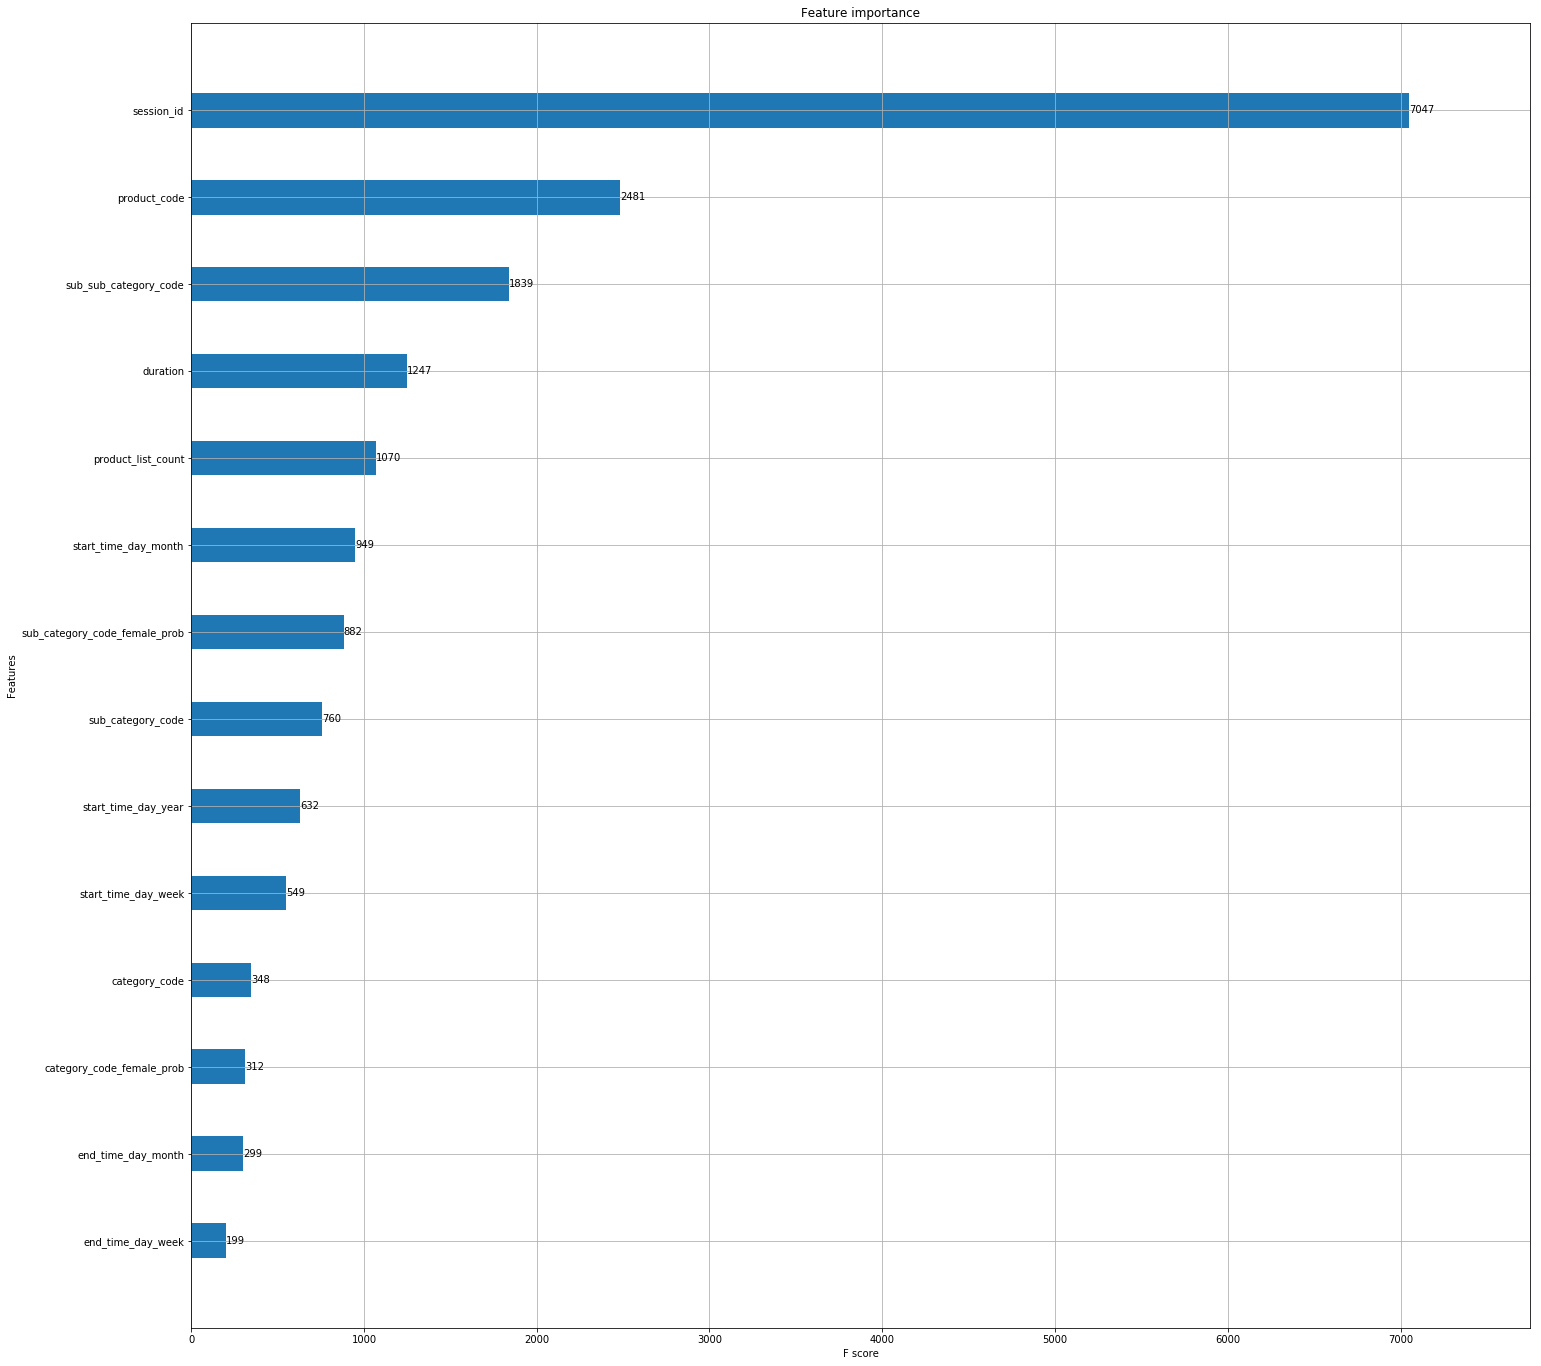

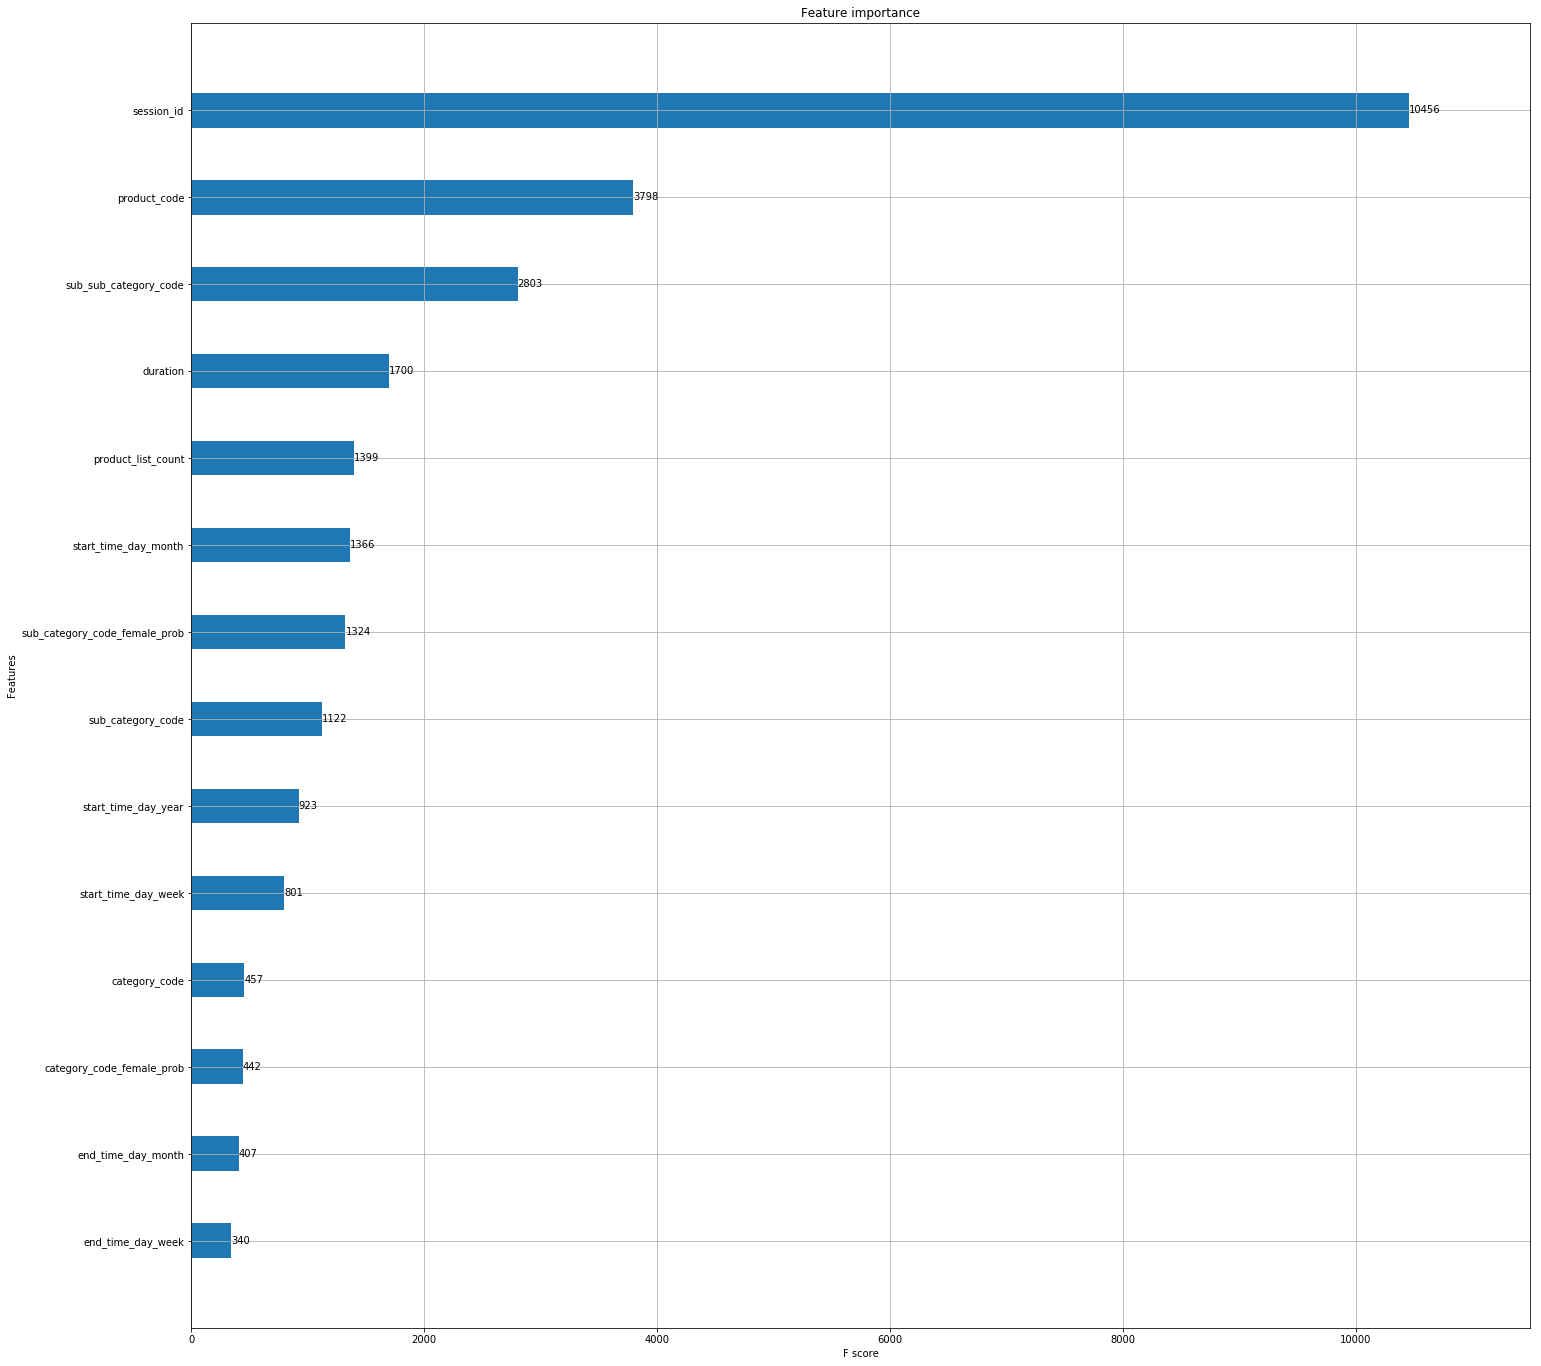

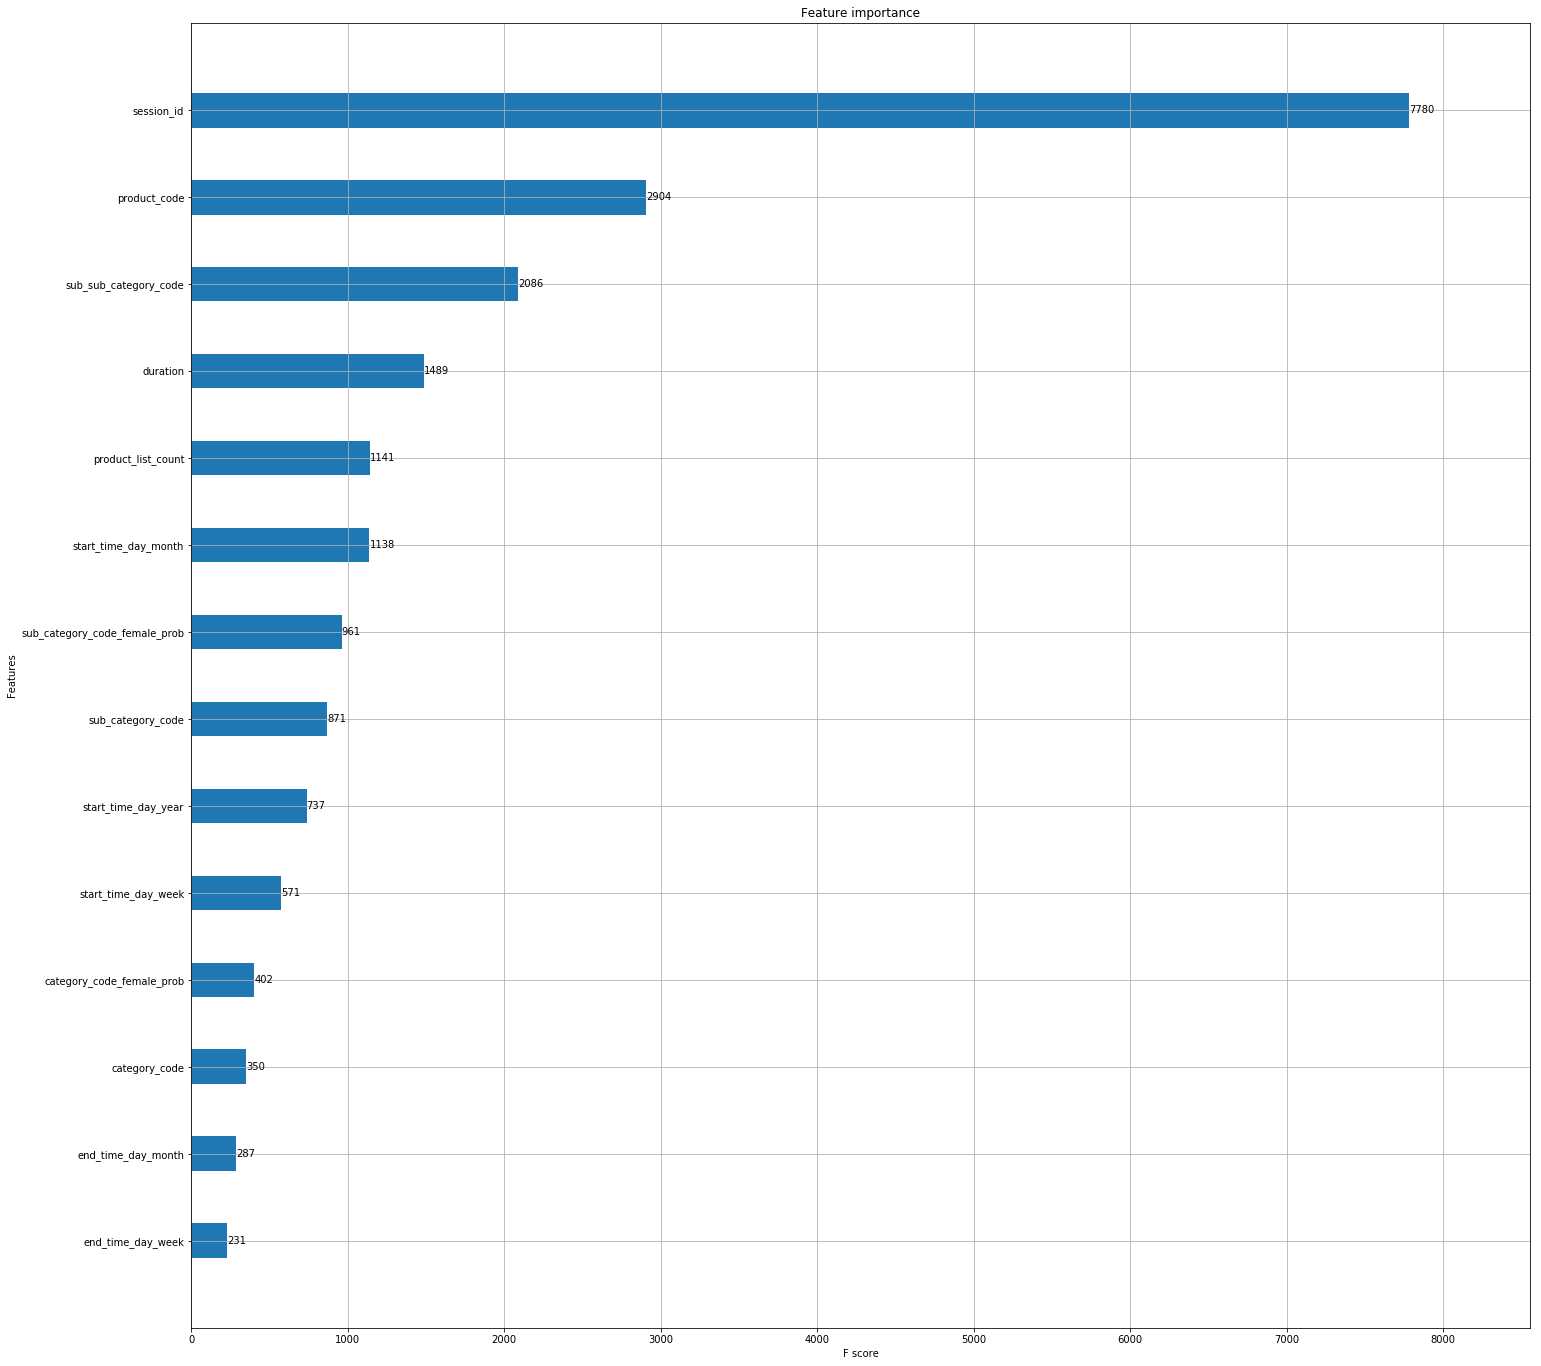

In [31]:
gss = GroupShuffleSplit(n_splits=3, train_size=0.9, random_state=42)
test_prob_preds = np.zeros(test.shape[0])

for idx, (train_idx, valid_idx) in enumerate(gss.split(train[feat], train[target], train['session_id']), 1):
    print("--"*40)
    print("Iteration Number  : {}".format(idx))
    MAX_ROUNDS=2000
    early_stopping_rounds=100
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'learning_rate': 0.1,
        'num_round': MAX_ROUNDS,
        'max_depth': 8,
        'seed': 13,
        'nthread': -1
    }

    X_train, X_valid, y_train, y_valid = train[feat].iloc[train_idx], train[feat].iloc[valid_idx], train[target].iloc[train_idx], train[target].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50
    )
    print("Best Iteration :: {} \n".format(model.best_iteration))

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(test[feat]), ntree_limit=model.best_ntree_limit)
    
    test_prob_preds += preds

test_prob_preds /= gss.n_splits
print(test_prob_preds.shape, test_prob_preds[: 5])

#### Now we have to take mean of the probabilities for all the session_ids to calculate male or female.

In [32]:
def preds_to_sub(sub, test, preds, le_dict):
    if 'gender' in sub.columns.tolist():
        sub.drop(['gender'], axis=1, inplace=True)
    test['sub'] = np.nan
    test['sub'] = preds
    agg = test.groupby(['session_id'])['sub'].mean().reset_index()
    agg['session_id'] = le_dict['session_id'].inverse_transform(agg[['session_id']])
    sub = pd.merge(sub, agg, on=['session_id'], how='left')
    sub.rename({
        "sub": target
    }, axis=1, inplace=True)
    sub[target] = sub[target].apply(lambda x: round(x))
    sub[target] = sub[target].map({1: "male", 0: "female"})
    
    return sub

### Making the final submission

In [33]:
sub = preds_to_sub(sub, test, test_prob_preds, le_dict)
print(sub[target].value_counts())
sub.to_csv("../subs/final_sub.csv", index=False)

sub.head()

female    3678
male       822
Name: gender, dtype: int64


,session_id,gender
0,u12112,female
1,u19725,female
2,u11795,female
3,u22639,male
4,u18034,male
